<a href="https://colab.research.google.com/github/Yakov-Jak/ML_in_business/blob/main/4_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install scikit-uplift catboost==0.22 -U

     |████████████████████████████████| 64.4 MB 9.5 kB/s 


In [17]:
!pip install causalml

     |████████████████████████████████| 243 kB 5.5 MB/s 
     |████████████████████████████████| 326 kB 38.0 MB/s 
     |████████████████████████████████| 1.8 MB 30.4 MB/s 
     |████████████████████████████████| 678 kB 35.0 MB/s 
  Created wheel for causalml: filename=causalml-0.11.1-cp37-cp37m-linux_x86_64.whl size=496025 sha256=55001b6ee36677ef9f95affbbef374f3d6e47e55b9d819fbf8050900eb686de0
  Stored in directory: /root/.cache/pip/wheels/38/37/65/b1ce7cd05b4de8f6e7a7714750c907b0d28fb93880d52e8a29
  Created wheel for shap: filename=shap-0.37.0-cp37-cp37m-linux_x86_64.whl size=465062 sha256=b3eab24b3731d6b944c2a898e25b914990dc1f29d6f8c8e8c98711de3868a375
  Stored in directory: /root/.cache/pip/wheels/df/b8/18/2c0a6105152e62dd9a7cf47b5110b9cedb0c8739babdef64b7
Successfully built causalml shap


In [18]:
!pip install scikit-uplift

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
path = '/gdrive/MyDrive/Colab Notebooks/4-Lesson/'

In [3]:
import pandas as pd


In [4]:

df = pd.read_csv(path+"data.csv")
print(df.shape)

(64000, 9)


In [5]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [6]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
df.loc[df['offer'] != 'No Offer', 'offer'] = 1
df.loc[df['offer'] == 'No Offer', 'offer'] = 0

In [9]:
df = df.rename(columns={'offer': 'treatment', 'conversion': 'target'})

In [10]:
com = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'treatment']

X_train, X_test, y_train, y_test = train_test_split(df[com], df['target'], test_size=0.25, random_state=0)

In [11]:
cat_features = ['zip_code', 'channel']

In [12]:
X_trft = X_train.drop('treatment', 1) # Тренировочная
X_trtr = X_train['treatment']
X_tstft = X_test.drop('treatment', 1) # Тестовая
X_tsttr = X_test['treatment']

In [32]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [14]:
df.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [19]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

In [33]:

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_trft, y_train, X_trtr, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_tstft)

# размер uplift на топ k процентах выборки
sm_score_1 = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=X_tsttr, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k( y_true=y_test, uplift=uplift_sm, treatment=X_tsttr, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

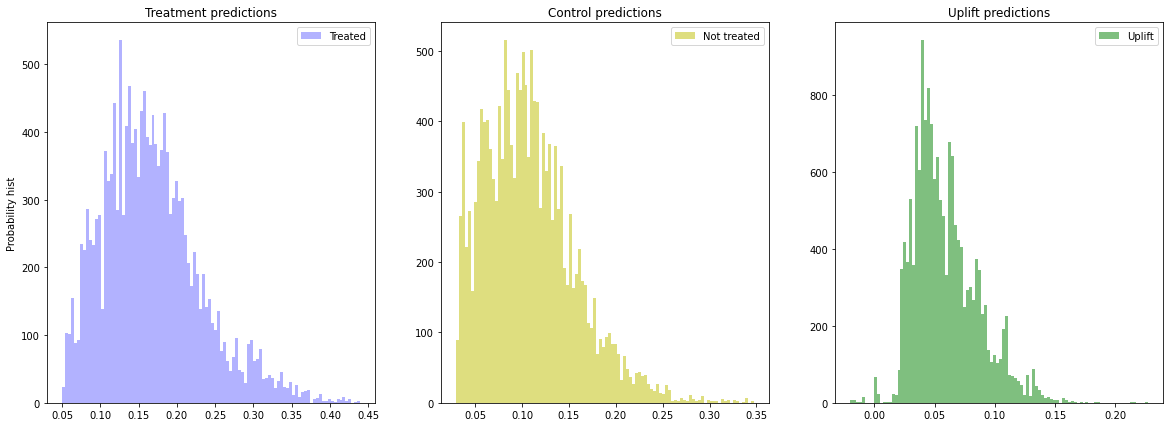

In [22]:
# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(sm_trmnt_preds , sm_ctrl_preds, bins=100);#ctrl_preds=

In [34]:
models_results

{'approach': ['SoloModel'],
 'uplift@10%': [0.07692470927765044],
 'uplift@20%': [0.07256580621897932]}

In [35]:
from sklift.viz import plot_uplift_curve

In [36]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,19.124219
1,is_referral,18.040223
2,used_bogo,14.881875
3,zip_code,10.928437
4,used_discount,10.492347
5,recency,9.221347
6,history,9.154900
7,channel,8.156653


In [37]:
from sklift.models import ClassTransformation

In [38]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_trft, y_train, X_trtr, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_tstft)

ct_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_tsttr, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_tsttr, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

In [39]:
models_results

{'approach': ['SoloModel', 'ClassTransformation'],
 'uplift@10%': [0.07692470927765044, 0.06470694338341396],
 'uplift@20%': [0.07256580621897932, 0.06431793435993158]}

In [40]:
from sklift.models import TwoModels

In [41]:
tm = TwoModels(  
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)   

# method ='ddr_control' ('ddr_treatment') - зависимые модели
tm = tm.fit(
    X_trft, y_train, X_trtr,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_tstft)

tm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_tsttr, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_tsttr, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)

Solo Model


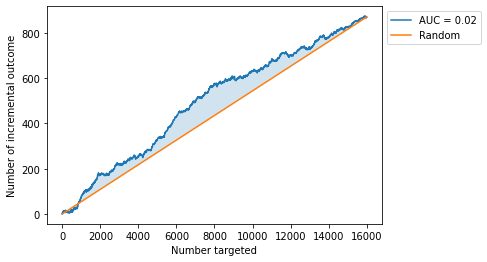

ClassTransform Model


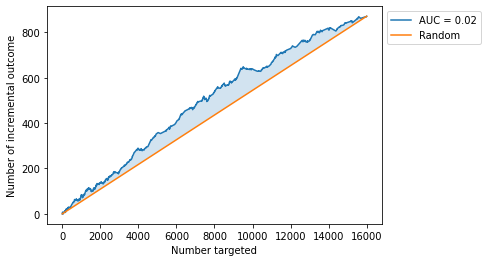

Two Model


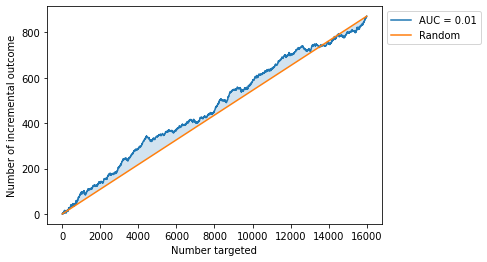

In [42]:
print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, X_tsttr, perfect=False)
plt.show()

print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, X_tsttr, perfect=False)
plt.show()

print('Two Model')
plot_uplift_curve(y_test, uplift_tm, X_tsttr, perfect=False)
plt.show()

In [43]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@10%': [0.07692470927765044, 0.06470694338341396, 0.07433579492403022],
 'uplift@20%': [0.07256580621897932, 0.06431793435993158, 0.07698470354501619]}

In [44]:
from tabulate import tabulate

In [45]:
table=[[models_results['approach'][0], models_results['uplift@10%'][0], models_results['uplift@20%'][0]],
       [models_results['approach'][1], models_results['uplift@10%'][1], models_results['uplift@20%'][1]],
       [models_results['approach'][2], models_results['uplift@10%'][2], models_results['uplift@20%'][2]]]
headers=["Model", "UpLift@10%", "UpLift@20%"]
print(tabulate(table, headers, tablefmt="grid"))

+---------------------+--------------+--------------+
| Model               |   UpLift@10% |   UpLift@20% |
+=====================+==============+==============+
| SoloModel           |    0.0769247 |    0.0725658 |
+---------------------+--------------+--------------+
| ClassTransformation |    0.0647069 |    0.0643179 |
+---------------------+--------------+--------------+
| TwoModels           |    0.0743358 |    0.0769847 |
+---------------------+--------------+--------------+


Примечательно, что у двойной модели значение аплифта20% больше, чем аплифт10. Можно сделать вывод о более низкой скорости падения значения аплифта от наибольших значений к меньшим

In [56]:
X_train_tree = pd.concat([X_trft.drop('zip_code', 1), 
                          pd.get_dummies(X_trft['zip_code'], prefix='zip_code')], 1)
X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)

In [58]:
X_val_tree = pd.concat([X_tstft.drop('zip_code', 1), 
                          pd.get_dummies(X_tstft['zip_code'], prefix='zip_code')], 1)
X_val_tree = pd.concat([X_val_tree.drop('channel', 1), 
                          pd.get_dummies(X_val_tree['channel'], prefix='channel')], 1)

In [59]:
features = [col for col in X_train_tree]

In [61]:
from IPython.display import Image, display
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


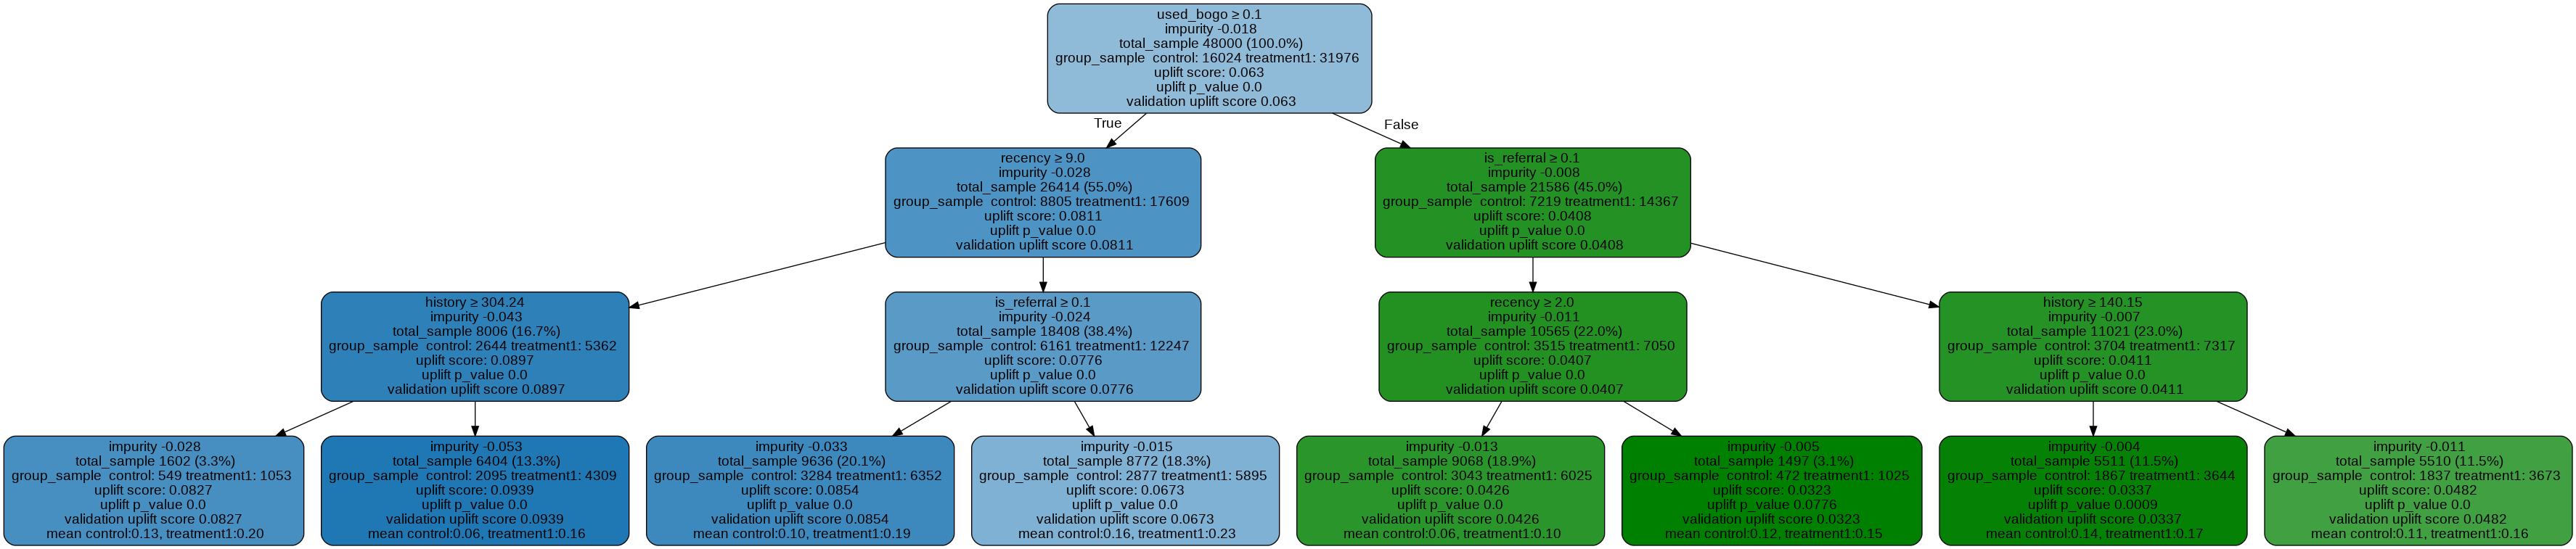

In [75]:
uplift_model = UpliftTreeClassifier(max_depth=4, min_samples_leaf=100, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=X_trtr.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
display(Image(graph.create_png()))

Описание по ветке максимального аплифта.
1. Сначала определяем совершал ли клиент покупки подряд.
2. Если да - смотрим срок последней покупки больше 9 месяцев
3. Если да - смотрим стоимость покупки
4. Те, кто совершал недорогие покупки (меньше 304) имеют максимальный аплифт.
Дерево максимально разделило клиентов на первом вопросе: Покупали ли клиенты подряд.

In [76]:
y_tree = uplift_model.predict(X_val_tree.values)

In [77]:
tree_lift =  y_tree[1]

tree_score_1 = uplift_at_k(y_true=y_test, uplift=tree_lift, treatment=X_tsttr, strategy='by_group', k=0.1)
tree_score_2 = uplift_at_k(y_true=y_test, uplift=tree_lift, treatment=X_tsttr, strategy='by_group', k=0.2)

In [ ]:
models_results['approach'].append('Tree')
models_results['uplift@10%'].append(tree_score_1)
models_results['uplift@20%'].append(tree_score_2)

In [ ]:
models_results